# ICG model training

Repoduction du tutoriel : https://data-flair.training/blogs/python-based-project-image-caption-generator-cnn/

# Setup ⚙️

In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import requests
from pathlib import Path
from tqdm.notebook import tqdm
import string
from pickle import dump, load
from PIL import Image
import os
import seaborn as sns
import pymysql

# KERAS
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

## MySql connection

In [ ]:
conn = pymysql.connect(host="localhost", port=3306, password="ycvnpgj6", user="root")
cur = conn.cursor()

## Download files ⬇️

<span style="color:red">***Skip if you already own files***</span>

In [ ]:
# Start by making directory to store datas (relative to this notebook)
Path("../data").mkdir(parents=True, exist_ok=True)

In [2]:
pictures_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"
text_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"

In [ ]:
def downloadFileUrl(url, dirPath, fileName):
    response = requests.get(url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kilobyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(dirPath+fileName, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()
    if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
        print("ERROR, something went wrong")

In [ ]:
downloadFileUrl(text_url, "../data/", "text.zip")
downloadFileUrl(pictures_url, "../data/", "pictures.zip")

## Unzip files 🗃

<span style="color:red">***Skip if you already own files***</span>

In [ ]:
# Pictures extraction   
with ZipFile("../data/pictures.zip", 'r') as zip_ref:
    zip_ref.extractall("../data/img/")
    # Text extraction
with ZipFile("../data/text.zip", 'r') as zip_ref:
    zip_ref.extractall("../data/text/")

# ℹ️ Text dataset infos

In [ ]:
# Read Datas from database
df_text = pd.read_sql(conn, "SELECT * FROM 

In [3]:
# read datas with pandas
df_text = pd.read_csv("../data/text/Flickr8k.lemma.token.txt", sep="\t", names=["img_name", "description"])
df_text.head(5)

img_name  \
0  1305564994_00513f9a5b.jpg#0   
1  1305564994_00513f9a5b.jpg#1   
2  1305564994_00513f9a5b.jpg#2   
3  1305564994_00513f9a5b.jpg#3   
4  1305564994_00513f9a5b.jpg#4   

                                         description  
0  A man in street racer armor be examine the tir...  
1         Two racer drive a white bike down a road .  
2  Two motorist be ride along on their vehicle th...  
3  Two person be in a small race car drive by a g...  
4       Two person in race uniform in a street car .

In [4]:
df_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40460 entries, 0 to 40459
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   img_name     40460 non-null  object
 1   description  40460 non-null  object
dtypes: object(2)
memory usage: 632.3+ KB


In [5]:
df_text["description"].describe()

count                          40460
unique                         40079
top       Two dog play in the snow .
freq                              11
Name: description, dtype: object

In [6]:
df_text["description"].apply(len).max()

185

In [7]:
df_text["description"].value_counts()

Two dog play in the snow .                                          11
Two dog run through a field .                                        7
A dog run through the grass .                                        7
Two dog play in the grass .                                          6
A person on a bmx bike .                                             6
                                                                    ..
a man hold a pro Judea protest sign at a protest rally               1
A man in yellow stand between two waterfall .                        1
Man ride bike in forest                                              1
A dog carry an object in the snow .                                  1
One boy push a shop cart with another small boy stand up in it .     1
Name: description, Length: 40079, dtype: int64

# Loading functions

In [9]:
# Loading a text file into memory
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [10]:
# get all imgs with their captions
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        img, caption = caption.split('\t')
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions

# 🧹 Text dataset pre-processing

In [11]:
#Data cleaning- lower casing, removing puntuations and words containing numbers
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

In [12]:
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

In [13]:
#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [14]:
# Set these path according to project folder in you system
dataset_text = "../data/text/"
dataset_images = "../data/img/Flicker8k_Dataset/"

In [15]:
#we prepare our text data
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions(filename)
print("Length of descriptions =" ,len(descriptions))
#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)
#building vocabulary 
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
#saving each description to file 
save_descriptions(clean_descriptions, "descriptions.txt")

Length of descriptions = 8092
Length of vocabulary =  8763


# Picture feature extraction

In [16]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img] = feature
        return features
#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))

  0%|          | 0/8091 [00:00<?, ?it/s]

In [17]:
dump(features, open("features.p","wb"))

In [18]:
features = load(open("features.p","rb"))

In [19]:
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

In [20]:
def load_clean_descriptions(filename, photos):
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

In [21]:
def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [22]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

7577

In [23]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

32

In [24]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield ([input_image, input_sequence], output_word)

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((47, 2048), (47, 32), (47, 7577))

# Model construction 🏗

In [25]:
from keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

# Training 🧠

In [39]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# making a directory models to save our models
Path("./models").mkdir(parents=True, exist_ok=True)
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 32, 256)      1939712     input_25[0][0]                   
__________________________________________________________________________________________________
dropout_22 (Dropout)            (None, 2048)         0           input_24[0][0]    

# Testing

In [149]:
def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
         if index == integer:
            return word
    return None
def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

# Load A file and predict

In [150]:
max_length = 32
xception_model = Xception(include_top=False, pooling="avg")
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_9.h5')
def consume(img_path):
    photo = extract_features(img_path, xception_model)
    description = generate_desc(model, tokenizer, photo, max_length)
    return description

In [163]:
from IPython.display import Image as imgshow
img_paths = ["./test_images/test3.jpg", "./test_images/test2.jpeg", "./test_images/test1.jpeg", "./test_images/golf.jpg", "./test_images/golf2.png"]
for img in img_paths:
    print(img)
    imgshow(filename=img)
    result = consume(img)
    print(result)

./test_images/test3.jpg
start man in red shirt is standing on the sidewalk end
./test_images/test2.jpeg
start man in red shirt is standing in front of crowd end
./test_images/test1.jpeg
start man in red shirt is standing on the sidewalk end
./test_images/golf.jpg
start two men play cricket on field end
./test_images/golf2.png
start two boys are playing soccer on grass end


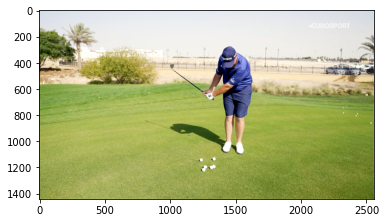

In [162]:
import matplotlib.image as mpimg
img = mpimg.imread('./test_images/golf2.png')
imgplot = plt.imshow(img)
plt.show()